# Random Forest and Boosting
CS109 Final Project

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
%matplotlib inline

In [2]:
df = pd.read_csv('age_dataset.csv', sep='\t')
del df['Unnamed: 0']

In [3]:
print(df.columns, df.isnull().sum(axis=0).tolist())

Index(['FIRST_NAME', 'GEN16', 'LAST_NAME', 'district', 'dob', 'electiondate',
       'female', 'id', 'party', 'regyear', 'typeofvote', 'zip', 'Prediction',
       'Race', 'age'],
      dtype='object') [2, 0, 2, 0, 431, 16297, 10, 0, 0, 0, 16297, 5, 2, 0, 431]


In [4]:
df['femaleis1'] = 0
df.loc[(df['female'] == "F"),'femaleis1'] = "1"

remove = ['FIRST_NAME', 'LAST_NAME', 'dob', 'electiondate',
       'female', 'id', 'regyear', 'typeofvote', 'zip']
        
df.drop(remove, axis = 1, inplace = True)

In [5]:
df = df.dropna()
df.head()

,GEN16,district,party,Prediction,Race,age,femaleis1
0,1.0,MRT,REP,Jewish,5,67.0,0
1,1.0,CLA,REP,Western European,5,35.0,1
2,0.0,HIL,DEM,Western European,3,20.0,0
3,1.0,MON,NPA,Western European,5,43.0,0
4,1.0,BAK,REP,Western European,5,52.0,0


In [6]:
df.isnull().sum(axis=0).tolist()

[0, 0, 0, 0, 0, 0, 0]

In [7]:
# Create dummies
df = pd.get_dummies(df, columns=['district','party', 'Prediction', 'Race'], drop_first=True)

In [8]:
# Train/test split
msk = np.random.rand(len(df)) < 0.5
train = df[msk]
test = df[~msk]

print ("Total Sample:", len (df))
print ("Test Sample:", len(test))
print ("Train Sample:", len(train))

Total Sample: 99567
Test Sample: 49481
Train Sample: 50086


In [9]:
# Create X and y split
X_train = train.iloc[:, train.columns != 'GEN16']
y_train = train['GEN16']
X_test = test.iloc[:, test.columns != 'GEN16']
y_test = test['GEN16']

### Random Forests

In [10]:
# Fit random forests for different numbers of trees
train_scores = []
test_scores = []
trees = [2**x for x in range(1,9)]
for n_trees in trees:
    rf = RandomForestClassifier(n_estimators=n_trees, max_features='sqrt')
    test_scores.append(metrics.accuracy_score(y_test, rf.fit(X_train, y_train).predict(X_test)))
    train_scores.append(metrics.accuracy_score(y_train, rf.fit(X_train, y_train).predict(X_train)))

In [11]:
print("Training Accuracies:", train_scores, "\nTest Accuracies:", test_scores)

Training Accuracies: [0.89623846983188915, 0.93203689653795474, 0.94593299524817309, 0.95266142235355189, 0.95591582478137604, 0.95677434812123152, 0.95691410773469632, 0.95693407339376269] 
Test Accuracies: [0.74869141690749985, 0.78381601018572788, 0.79721509266182977, 0.8013378872698611, 0.80473312988823997, 0.80548089165538284, 0.80614781431256444, 0.80744124007194684]


In [12]:
# Apply 5-fold cross-validation to determine optimal number of predictors
n = []
predictors = [x for x in range(1, 92)]
for n_predictors in predictors:
    rf = RandomForestClassifier(n_estimators=4, max_features=n_predictors)
    scores = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=5, n_jobs=-1)
    n.append((n_predictors, scores.mean()))

In [13]:
best_number = np.argmax(np.array(n)[:,1]) + 1
print("Optimal number of predictors is:", best_number)

Optimal number of predictors is: 47


In [14]:
# Determine accuracy on train and test
rf = RandomForestClassifier(n_estimators=128, max_features=best_number)
print("Accuracy on Train:", metrics.accuracy_score(y_train, rf.fit(X_train, y_train).predict(X_train)))
print("Accuracy on Test:", metrics.accuracy_score(y_test, rf.fit(X_train, y_train).predict(X_test)))

Accuracy on Train: 0.956914107735
Accuracy on Test: 0.814939067521


### Boosting

In [16]:
# Use AdaBoost with learning rate of 0.05
accuracies_train = []
accuracies_test = []
trees = [2**x for x in range(1,7)]
for md in [1,2,10,None]:
    depth_accuracies_train = []
    depth_accuracies_test = []
    for n in trees:
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=md),n_estimators=n, learning_rate=.05)
        depth_accuracies_train.append(metrics.accuracy_score(y_train, ada.fit(X_train,y_train).predict(X_train)))
        depth_accuracies_test.append(metrics.accuracy_score(y_test, ada.fit(X_train,y_train).predict(X_test)))
    accuracies_train.append(depth_accuracies_train)
    accuracies_test.append(depth_accuracies_test)

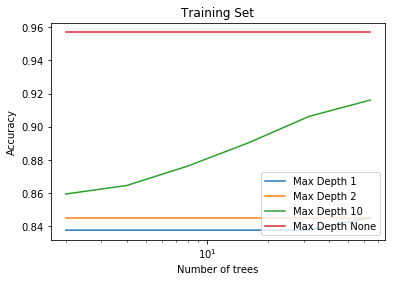

In [17]:
# Create plot showing how depth and number of trees relate to accuracy for training set
for i, md in enumerate([1,2,10,None]):
    plt.semilogx(trees, accuracies_train[i], label='Max Depth {}'.format(md))
plt.legend(loc=4)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Training Set')
plt.show()

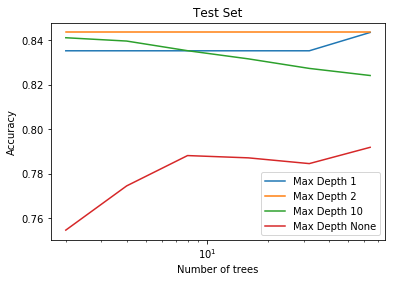

In [18]:
# Create plot showing how depth and number of trees relate to accuracy for test set
for i, md in enumerate([1,2,10,None]):
    plt.semilogx(trees, accuracies_test[i], label='Max Depth {}'.format(md))
plt.legend(loc=4)
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Test Set')
plt.show()

In [19]:
# 5-fold cross validation to choose optimal depth and number of trees
cv_results = []
trees = [2**x for x in range(1,7)]
depth = [1,2,10,None]
depth_accuracies_train = []
depth_accuracies_test = []
for d in depth:
    for t in trees:
        ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=d),n_estimators=t, learning_rate=.05)
        depth_accuracies_train.append(metrics.accuracy_score(y_train, ada.fit(X_train,y_train).predict(X_train)))
        depth_accuracies_test.append(metrics.accuracy_score(y_test, ada.fit(X_train,y_train).predict(X_test)))     
    scores = cross_val_score(estimator=ada, X=X_train, y=y_train, cv=5, n_jobs=-1)
    cv_results.append((d, t, scores.mean()))

In [20]:
position = np.argmax(np.array(cv_results)[:,2])
print("Optimal Depth:", cv_results[position][0], "Optimal Trees:", cv_results[position][1])

Optimal Depth: 2 
Optimal Trees: 64


In [22]:
# The optimal model has depth 2 and 64 trees
ada=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),n_estimators=64, learning_rate=.05)
print("Train Accuracy:", metrics.accuracy_score(y_train, ada.fit(X_train,y_train).predict(X_train)))
print("Test Accuracy:", metrics.accuracy_score(y_test, ada.fit(X_train,y_train).predict(X_test))) 

Train Accuracy: 0.845186279599
Test Accuracy: 0.843576322225
